# Comparisons with *in situ* SnowEx 2020 data and RS datasets

J. Michelle Hu  
SnowEx Hackweek 2021  
University of Washington  

### GOAL:
**Input:** time, space, dataset bounds, RS dataset, preprocessing choices
**Output:** aligned dataset(s)/data stack, comparison plots

### This notebook:
- pulls in data from the snowexsql database, using instrument type, product type, and date string ('yyyy-mm-dd')
- pulls in and processes full ASO snow depth raster for SnowEx 2020 (interchangeable with other snow depth raster)
- writes in situ data to tif using input raster (ASO snow depth) as template
- samples input raster at in situ locations (based on geometry)
- plots dataset distributions, difference distributions, and scatterplots of in situ and sampled RS raster values

#### TODO:

- add spatial extraction component (by shapefile, by bounding box, etc.)
- pull in raster tiles from snowexsql, stitch instead of looping in external data
- add snow depth to SWE calculations (2+ ways)
- add comparisons with external SWE raster (ASO SWE)
- move code prepping ASO rasters to new notebook

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from snowexsql.data import PointData, LayerData, ImageData

from sqlalchemy.sql import func 
from snowexsql.conversions import raster_to_rasterio 
from rasterio.plot import show

In [4]:
def fn_list(thisDir, fn_pattern):
    '''Function that returns a sorted list of filenames based on a regex pattern in specified directory'''
    import glob
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern):
        fns.append(f)
    fns.sort()
    return fns

def load(fn, name, masked=True):
    '''Function to open files with rasterio as xarray DataArrays'''
    arr=rioxarray.open_rasterio(fn, masked=masked, default_name=name).squeeze(dim='band', drop=True)
    return arr

def connect_db(db_name = 'snow:hackweek@52.32.183.144/snowex'):
    from snowexsql.db import get_db
    engine, session = get_db(db_name)
    return engine, session

## 1. Connect to db!

In [5]:
engine, session = connect_db()

#### 1a. See what types of image data are available

In [6]:
result = session.query(ImageData.type).distinct().all()
print('Available types = {}'.format(', '.join([r[0] for r in result])))

Available types = swe, DEM, insar amplitude, insar correlation, depth, insar interferogram real, insar interferogram imaginary


#### 1b. Check out some plots of image data

In [7]:
def query2plot(datatype, cmap='magma', vmin=None, vmax=None):
    result = session.query(func.ST_AsTiff(ImageData.raster)).filter(
    ImageData.type == datatype).limit(1).all()
    
    datasets = raster_to_rasterio(session, result)
    show(datasets[0], vmin=vmin, vmax=vmax, cmap=cmap)
    datasets[0].close()

##### ASO DB SWE

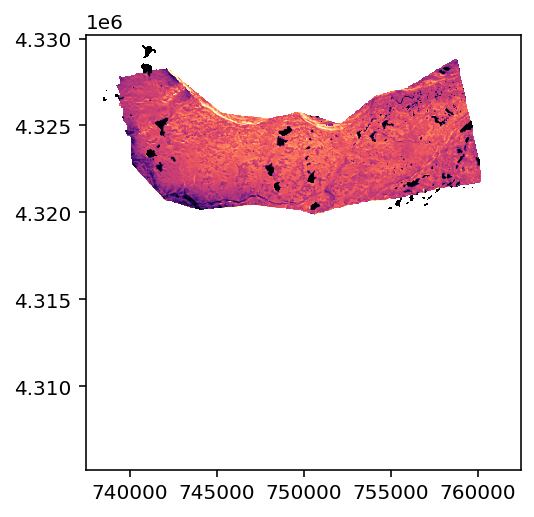

In [8]:
query2plot(datatype='swe', vmin=0, vmax=0.4)

##### ASO DB Snow Depth

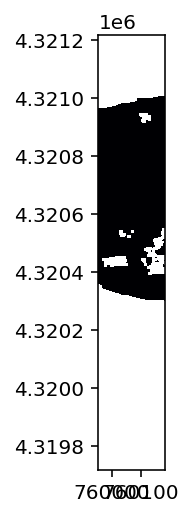

In [9]:
query2plot(datatype='depth', vmin=0, vmax=0.1)

### ... ==>>> no snow?

##### 3DEP DEM tile

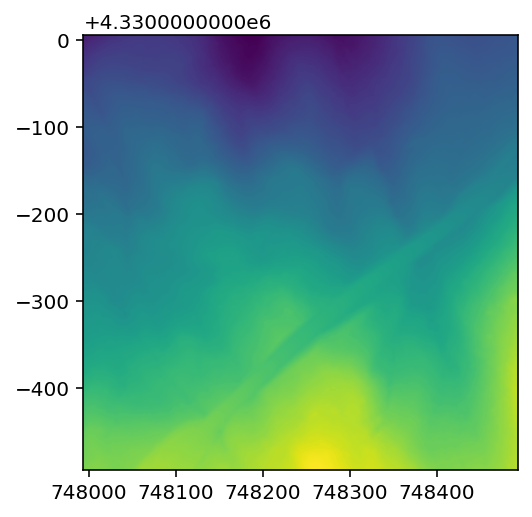

In [10]:
query2plot(datatype='DEM', cmap='viridis')

#### 1c. Check out unique surveyors of the Image Data

In [11]:
results = session.query(ImageData.surveyors).distinct().all()
print(results)

[('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


#### 1d. Try creating a single combo query for more info on the Image Data, omitting UAVSAR surveyors 

In [12]:
results = session.query(ImageData.type, 
                        ImageData.instrument, 
                        ImageData.description, 
                        ImageData.surveyors, 
                        func.ST_PixelWidth(ImageData.raster)
                       ).filter(ImageData.surveyors != "UAVSAR team, JPL").distinct().all()

for r in results:
    for line in r:
        print(line)
    print('\n')

swe
lidar
50m product
ASO Inc.
50.000101089121436


depth
lidar
3m snow depth product
ASO Inc.
3.000000000007304


DEM
lidar
US Geological Survey 1m snow off DEM from the 3DEP
USGS
1.0




#### 1e. Do the same for the Point Data depth products

In [13]:
results = session.query(PointData.type, 
                        PointData.instrument, 
                        PointData.surveyors, 
                       ).filter(PointData.type=='depth').distinct().all()

for r in results:
    for line in r:
        print(line)
    print('\n')

depth
mesa
None


depth
pit ruler
None


depth
camera
Catherine Breen, Cassie Lumbrazo


depth
magnaprobe
None


depth
pulse EKKO Pro multi-polarization 1 GHz GPR
Tate Meehan




In [14]:
results = session.query(LayerData.type, 
                        LayerData.instrument, 
                        LayerData.surveyors, 
                       ).distinct().all()

for r in results:
    for line in r:
        print(line)
    print('\n')

equivalent_diameter
IS3-SP-11-01F
Juha Lemmetyinen


specific_surface_area
IRIS
Céline Vargel


sample_signal
IS3-SP-15-01US
Kehan Yang


sample_signal
IRIS
Carrie Vuyovich


lwc_vol
None
None


sample_signal
IS3-SP-11-01F
Juha Lemmetyinen & Ioanna Merkouriadi


sample_signal
IS3-SP-11-01F
Juha Lemmetyinen


equivalent_diameter
IS3-SP-11-01F
Kate Hale


reflectance
IS3-SP-11-01F
Kate Hale


specific_surface_area
IS3-SP-11-01F
Juha Lemmetyinen


force
snowmicropen
None


reflectance
IS3-SP-11-01F
Carrie Vuyovich


sample_signal
IS3-SP-11-01F
Kate Hale


hand_hardness
None
None


specific_surface_area
IS3-SP-11-01F
Kate Hale


grain_size
None
None


equivalent_diameter
IRIS
Carrie Vuyovich


reflectance
IRIS
Céline Vargel


reflectance
IS3-SP-11-01F
Juha Lemmetyinen & Ioanna Merkouriadi


specific_surface_area
IS3-SP-11-01F
Juha Lemmetyinen & Ioanna Merkouriadi


temperature
None
None


reflectance
IRIS
Carrie Vuyovich


equivalent_diameter
IS3-SP-15-01US
Kehan Yang


equivalent_diameter

## 2. Prep the ASO snow depth raster

#### 2a. Snag the ASO full SD raster from SnowEx 2020

In [15]:
if not os.path.exists("ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0201/ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports.zip

if not os.path.exists("ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports/"):
    !unzip ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports.zip

#### 2b. Load the raster

In [16]:
aso_sd_2020=load("ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports/ASO_GrandMesa_2020Feb1-2_snowdepth_3m.tif", "SD (m)")

#### 2c. And plot it

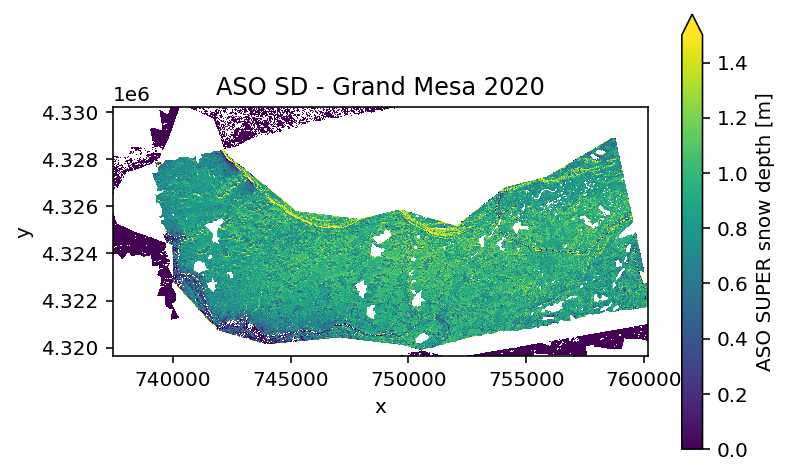

In [17]:
fig, ax = plt.subplots()
ax.set_aspect('equal');
aso_sd_2020.plot(vmin=0, vmax=1.5, ax=ax);
ax.set_title(f'ASO SD - Grand Mesa 2020');

#### ASO stuff in WGS84, need to be in NAD83 to match the in situ db bits

In [18]:
aso_sd_2020.rio.crs

CRS.from_epsg(32612)

In [19]:
aso_sd_2020=aso_sd_2020.rio.reproject(dst_crs="EPSG:26912")
aso_sd_2020.rio.crs

CRS.from_epsg(26912)

In [20]:
# Write to file
out_fn="ASO_GrandMesa_2020Feb1-2_snowdepth_3m_reproj.tif"
if not os.path.exists(out_fn):
    aso_sd_2020.rio.to_raster(out_fn)

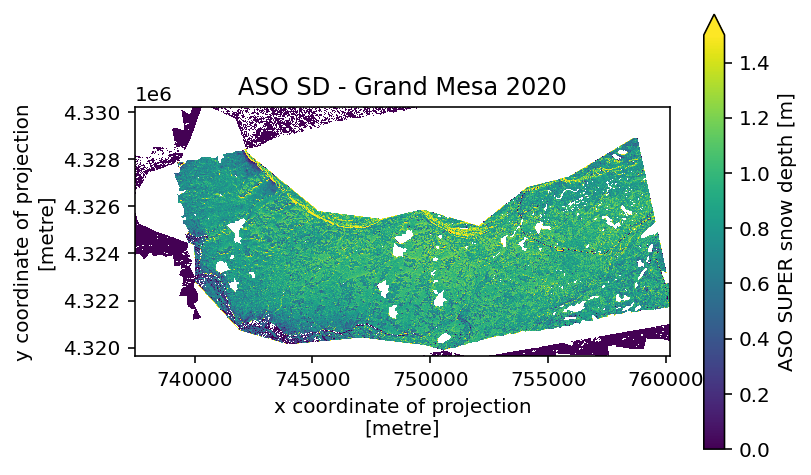

In [21]:
fig, ax = plt.subplots()
ax.set_aspect('equal');
aso_sd_2020.plot(vmin=0, vmax=1.5, ax=ax);
ax.set_title(f'ASO SD - Grand Mesa 2020');

## 3. Extract aso depths from db in situ point locations

#### 3a. Specify a day

In [22]:
# This is the start of the ASO flyover date
timestamp='2020-02-01'

# This is when there is a whole bunch of GPR
# timestamp='2020-01-28'

#### 3b. Add some helper functions to make things more readable

In [23]:
def grabngo(dataclass, dataset_type, instrument, timestamp, 
            session, engine, get_df=None):
    
    from snowexsql.conversions import query_to_geopandas
    q = session.query(dataclass).filter(
        PointData.type == dataset_type).filter(
        PointData.instrument == instrument).filter(
        PointData.date == timestamp
    )
    if get_df:
        df = query_to_geopandas(q, engine)
        return df

def quickplot(df, figsize=(8, 4), vmin=None, vmax=None, colname='value',
              cmap="PuBu", marker='.',
              legend=True, title=None, axes_off=None
             ):
    fig, ax = plt.subplots(figsize=figsize)
    df.plot(column=colname, ax=ax, 
            marker=marker, cmap=cmap, legend=legend, 
            vmin=vmin, vmax=vmax
           )
    if not title:
        ax.set_title(f'{df.loc[0].instrument}: {df.shape[0]} points');
    else:
        ax.set_title(title)
        
    if axes_off:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xlabel('UTM 12N Easting')
        ax.set_ylabel('UTM 12N Northing')

def check_entrydates(df):
    print(f'{df.instrument[0]} \n')
    for dt in df['date'].unique():
        num=df.loc[df['date']==dt].shape[0]
        print(f' {dt} has {num} entries')
        
def burn_baby_burn(template_fn, out_fn, gdf, fill_val=0):
    
    '''Function to burn the features to a raster template'''
    
    # Check out documentation for this burning https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster
    # may want to think about point sampling to grid (aggregation)
    
    import rasterio as rio
    from rasterio import features
    
    f=rio.open(template_fn)
    meta = f.meta.copy()
    meta.update(compress='lzw')

    with rio.open(out_fn, 'w+', **meta) as out:
        out_arr = out.read(1)

        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf.value))

        burned = features.rasterize(shapes=shapes, fill=fill_val, out=out_arr, transform=out.transform)
        out.write_band(1, burned)

In [24]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[ymin:ymax+1, xmin:xmax+1]

def extract_nonan_gdfs(raster, gdf, out_fn, check_all=None, ndv=-9999):
    
    '''Extract raster values with specified geometries'''
    
    extract_gdf=raster.rio.clip(gdf.geometry)
    extract_gdf.values[extract_gdf.values==ndv]=np.nan
    
    df_fromdisk=load(out_fn, 'in situ measures (cm)', masked=False)
    ndv=df_fromdisk._FillValue
    
    # specify for bbox2 extent clipping
    df_fromdisk.values[df_fromdisk.values==ndv]=0
    
    stripped=bbox2(df_fromdisk)
    stripped.values[stripped.values==0]=np.nan
    
    # Remove the nans from the raster clips
    extract_gdf_nonans=extract_gdf.values[~np.isnan(extract_gdf.values)]
    gdf_nonans=stripped.values[~np.isnan(extract_gdf.values)]
    
    if check_all:
        print(extract_gdf.shape, gdf.shape, np.isnan(extract_gdf.values).sum(), np.isnan(gdf.values).sum())
    
    return extract_gdf_nonans, gdf_nonans, extract_gdf, stripped

def check_extracts(extract1, extract2):
    print(extract1.shape, extract2.shape)
    print(np.isnan(extract1).sum(), np.isnan(extract2).sum())
    
def compare_depths(extract_gdf_nonans, insitu_gdf_nonans, adjust_meters=True,
                   style='white', figsize=(9, 4), sharey=True, 
                   histlabels=['ASO depths', 'Magnaprobe', 'ASO  - \nMagnaprobe'], 
                   histcolors=['darkblue', 'lightskyblue', 'mediumslateblue'],
                   xlabels=["Snow depth (m)", "Difference in snow depth (m)"],
                   title=f'Depth comparison (m)',
                   vlinecolor='k', vlinestyle="--",
                   xlims=[-0.5, 0.5],
                   jointcolor='lightseagreen', upper=None, lower=None, jointheight=5,
                   oneonestyle=':', oneonecolor='gray'
                  ):

    if adjust_meters:
        insitu_gdf_nonans=insitu_gdf_nonans/100
    plt.rcParams.update({'font.size': 12})
    sns.set_theme(style=style)

    fig, axa = plt.subplots(1, 2, figsize=figsize, sharey=sharey)
    ax=axa[0]
    sns.histplot(extract_gdf_nonans, 
                 label=histlabels[0], 
                 color=histcolors[0],
                 ax=ax
                )
    sns.histplot(insitu_gdf_nonans, 
                 label=histlabels[1], 
                 color=histcolors[1],
                 ax=ax
                )
    ax.set_xlabel(xlabels[0])
    ax.legend()

    ax=axa[1]
    sns.histplot(extract_gdf_nonans - insitu_gdf_nonans, 
                 label=histlabels[2], 
                 color=histcolors[2],
                 ax=ax
                )
    ax.vlines(0, 0, round(ax.get_ylim()[1], ndigits=4), color=vlinecolor, linestyle=vlinestyle)
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_xlabel(xlabels[1])
    ax.legend()

    plt.suptitle(title)
    plt.tight_layout()

    x=insitu_gdf_nonans
    y=extract_gdf_nonans
    s=sns.jointplot(x=x, y=y, color=jointcolor,
                    kind="hist", height=jointheight,
                   )
    

    # JointGrid has a convenience function
    s.set_axis_labels('$in situ$ depths (m)', 'RS depths (m)', fontsize=16, fontweight='bold')

    # or set labels via the axes objects
    s.ax_joint.set_xlabel('$in situ$ depths (m)', fontweight='bold')
    
    ax=s.ax_joint
    if not upper:
        upper=np.round(extract_gdf_nonans.max()*10+0.5, 0)/10
        lower=np.round(extract_gdf_nonans.min()*10-0.5, 0)/10
    ax.axline((lower,lower), (upper,upper), ls=oneonestyle, color=oneonecolor, label=f'1:1 line')
    q=sns.regplot(ax=ax, x=x, y=y, color=jointcolor, scatter=False)
    ax.legend()

#### 3c. Specify the template raster from which to do some burning

In [25]:
template_fn=out_fn
template_fn

'ASO_GrandMesa_2020Feb1-2_snowdepth_3m_reproj.tif'

#### 3d. Plot depth by product type, extract corresponding aso depths, burn to tifs and plot in situ - RS comparisons

##### Mesa2 depths

mesa 

 2020-02-01 has 553 entries


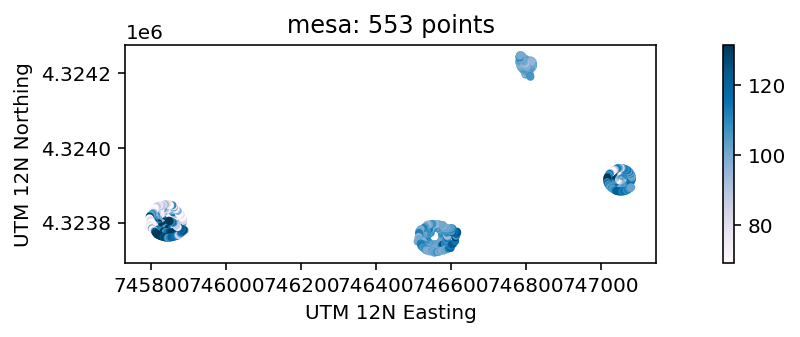

In [26]:
instrument='mesa'

df=grabngo(PointData, 'depth', instrument, timestamp, 
           session, engine, get_df=True)

quickplot(df, figsize=(12, 2), colname='value',
          vmin=np.percentile(df['value'], 5),
          vmax=np.percentile(df['value'], 95),
         )

check_entrydates(df)

# Burn to file
out_fn=f'{instrument}_depths_{timestamp}.tif'
gdf=df
if not os.path.exists(out_fn):
    burn_baby_burn(template_fn, out_fn, gdf)

(516,) (516,)
0 0


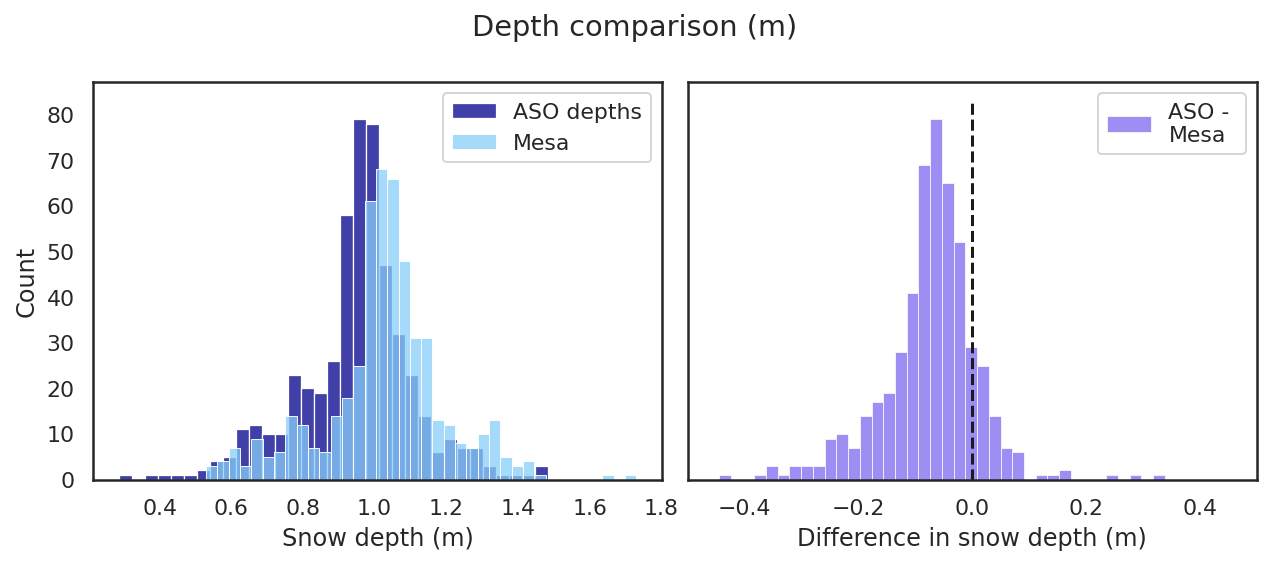

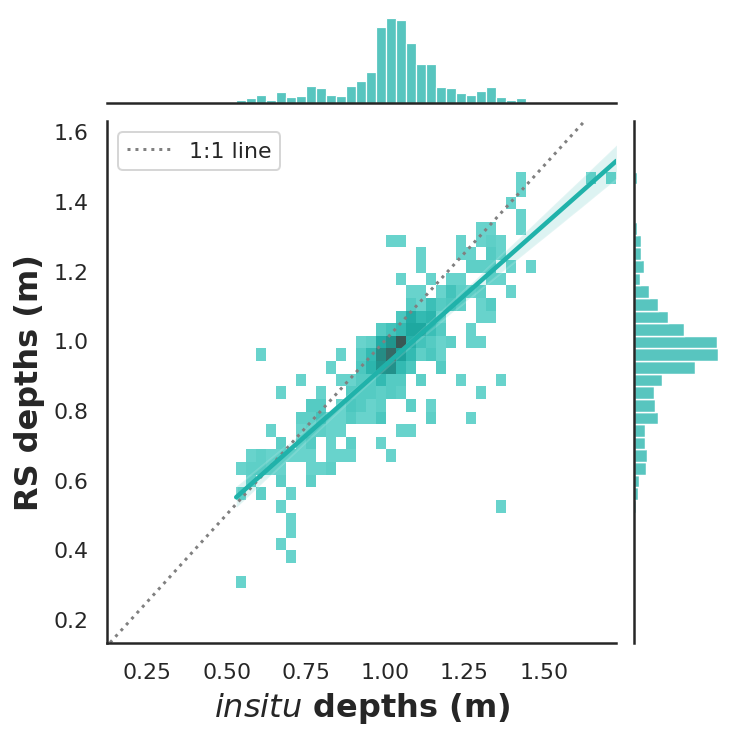

In [27]:
aso_sd_nonans, stripped_nonans, aso_sd_points, stripped = extract_nonan_gdfs(aso_sd_2020, df, out_fn=out_fn)
check_extracts(stripped_nonans, aso_sd_nonans)
compare_depths(aso_sd_nonans, stripped_nonans, histlabels=['ASO depths', f'{instrument.capitalize()}', f'ASO - \n{instrument.capitalize()}'],)

##### Pit ruler depths

pit ruler 

 2020-02-01 has 14 entries


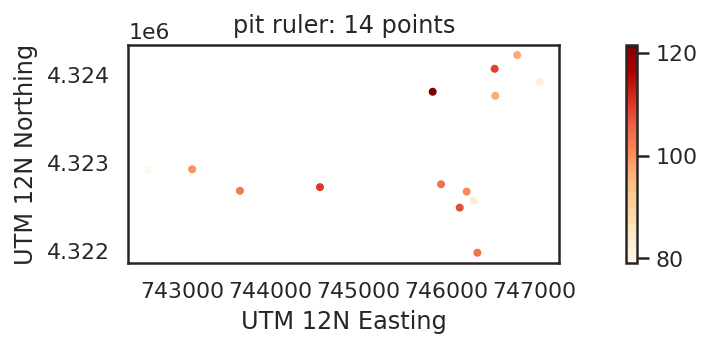

In [28]:
instrument='pit ruler'

df=grabngo(PointData, 'depth', instrument, timestamp, 
           session, engine, get_df=True)

quickplot(df, figsize=(12, 2), cmap='OrRd', vmin=np.percentile(df.value, 5),
        vmax=np.percentile(df.value, 95))

check_entrydates(df)

# Burn to file
if len(instrument.split(' '))>0:
    instrument='_'.join(instrument.split(' '))
    
out_fn=f'{instrument}_depths_{timestamp}.tif'
gdf=df
if not os.path.exists(out_fn):
    burn_baby_burn(template_fn, out_fn, gdf)

(14,) (14,)
0 0


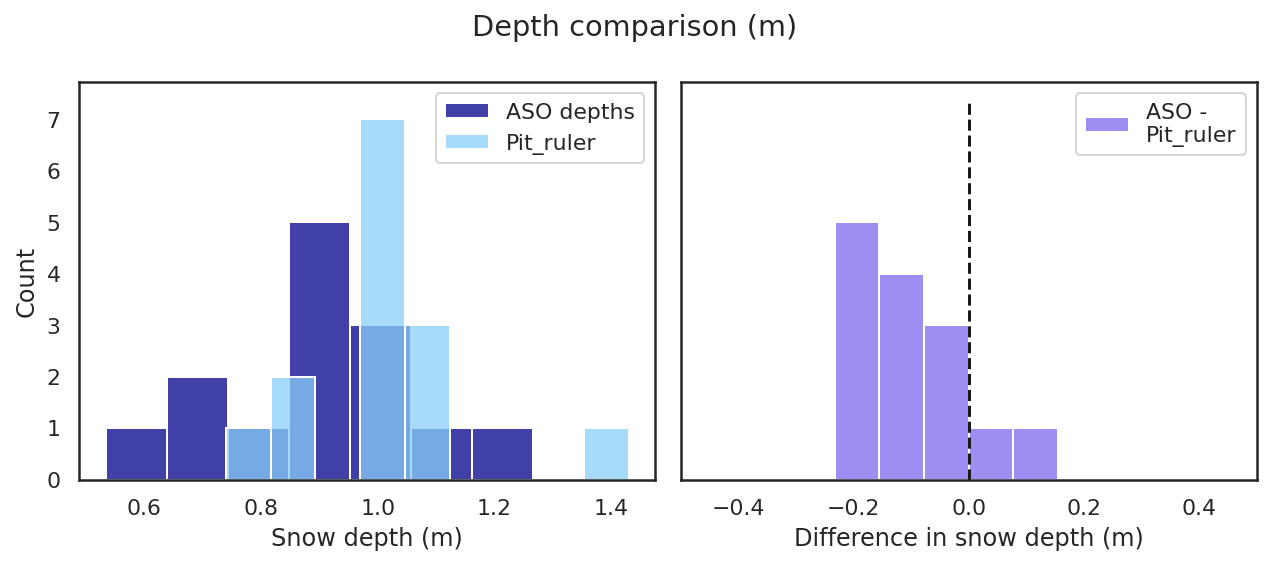

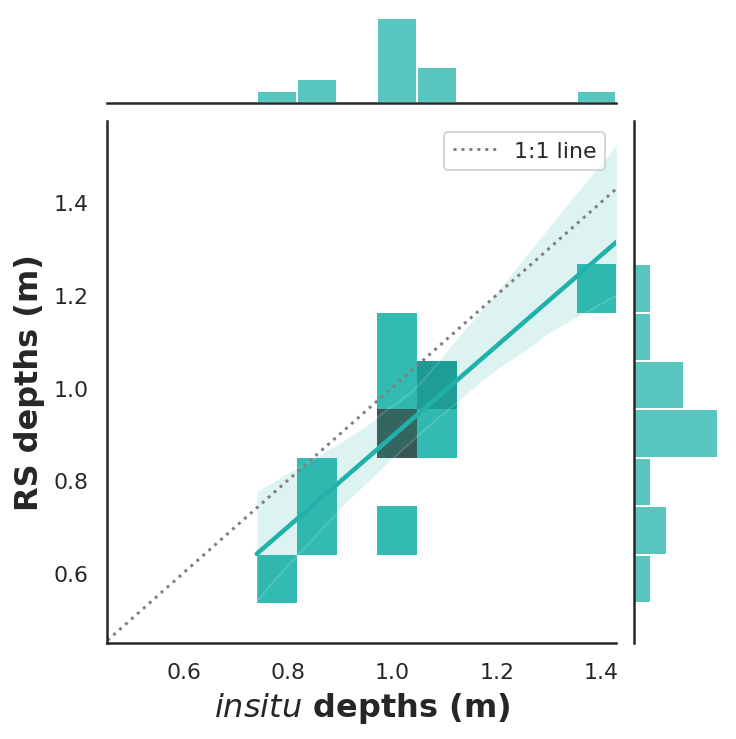

In [29]:
aso_sd_nonans, stripped_nonans, aso_sd_points, stripped = extract_nonan_gdfs(aso_sd_2020, df, out_fn=out_fn)
check_extracts(stripped_nonans, aso_sd_nonans)
compare_depths(aso_sd_nonans, stripped_nonans, histlabels=['ASO depths', f'{instrument.capitalize()}', f'ASO - \n{instrument.capitalize()}'],)

##### camera depths

camera 

 2020-02-01 has 54 entries


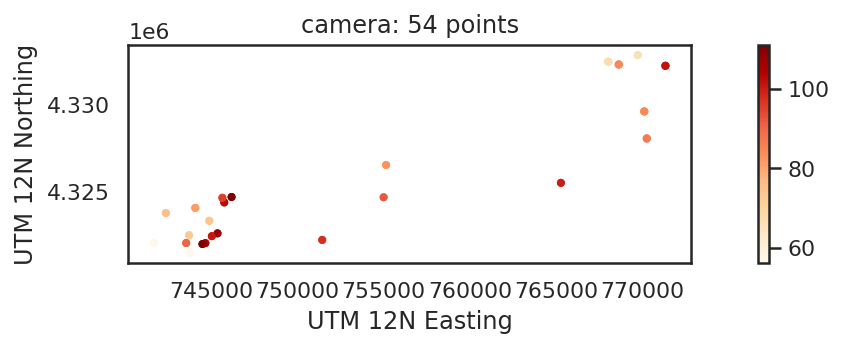

In [31]:
instrument='camera'

df=grabngo(PointData, 'depth', instrument, timestamp, 
           session, engine, get_df=True)

quickplot(df, figsize=(12, 2), cmap='OrRd', vmin=np.percentile(df.value, 5),
        vmax=np.percentile(df.value, 95))

check_entrydates(df)

# Burn to file
if len(instrument.split(' '))>0:
    instrument='_'.join(instrument.split(' '))

out_fn=f'{instrument}_depths_{timestamp}.tif'
gdf=df
if not os.path.exists(out_fn):
    burn_baby_burn(template_fn, out_fn, gdf)

(17,) (17,)
0 0


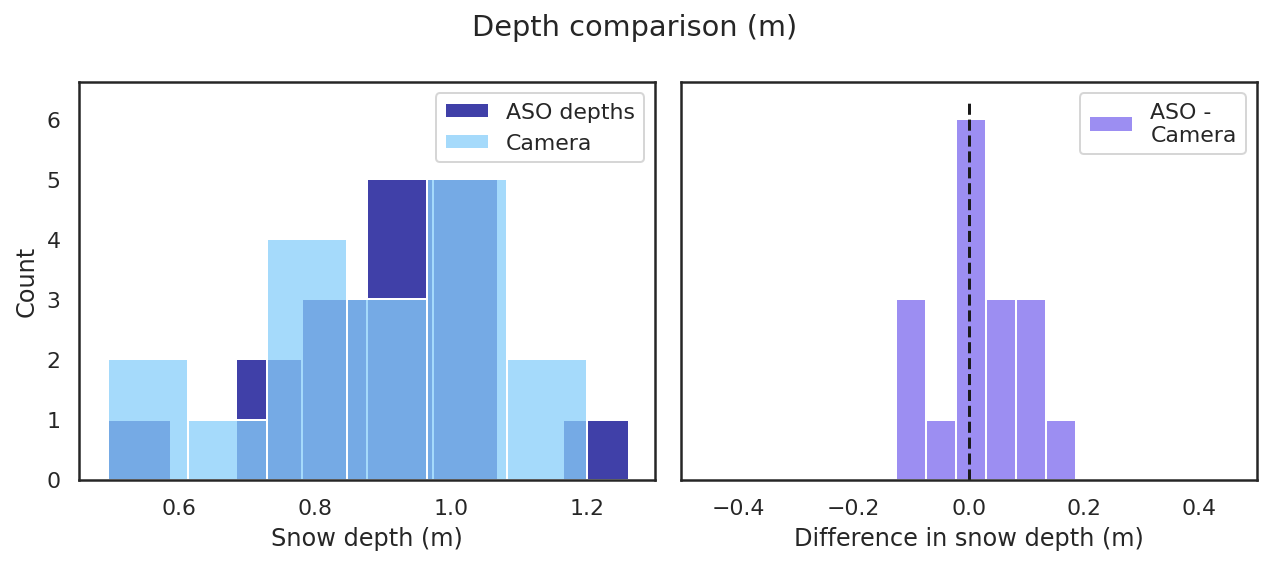

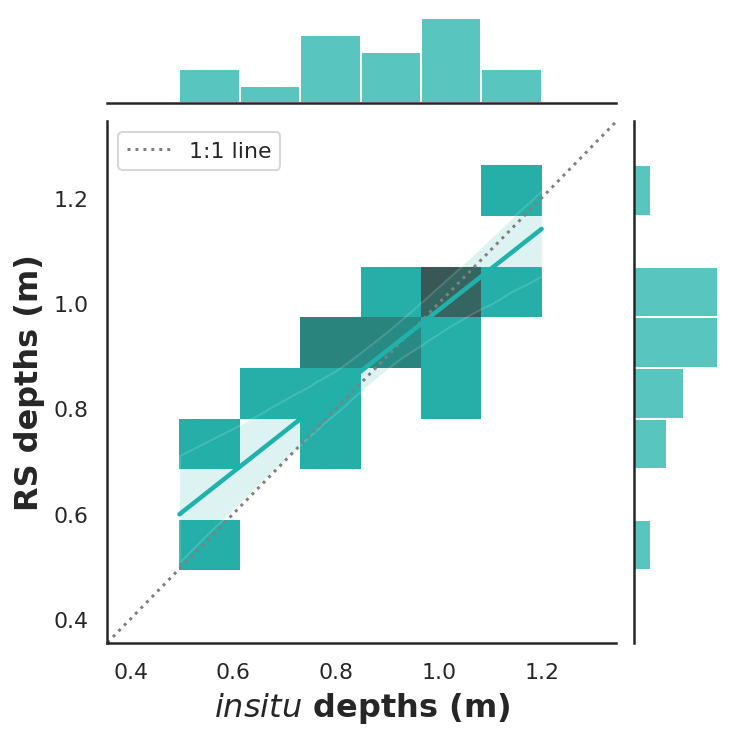

In [32]:
aso_sd_nonans, stripped_nonans, aso_sd_points, stripped = extract_nonan_gdfs(aso_sd_2020, df, out_fn=out_fn)
check_extracts(stripped_nonans, aso_sd_nonans)
compare_depths(aso_sd_nonans, stripped_nonans, histlabels=['ASO depths', f'{instrument.capitalize()}', f'ASO - \n{instrument.capitalize()}'],)

##### magnaprobe depths

magnaprobe 

 2020-02-01 has 4841 entries


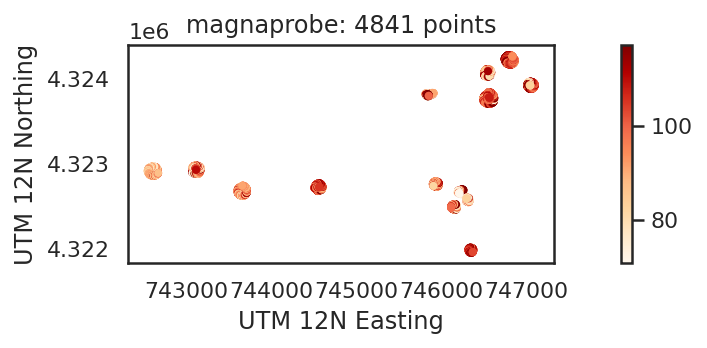

In [33]:
instrument='magnaprobe'

df=grabngo(PointData, 'depth', instrument, timestamp, 
           session, engine, get_df=True)

magna_df=df.copy()

quickplot(df, figsize=(12, 2), cmap='OrRd', vmin=np.percentile(df.value, 5),
        vmax=np.percentile(df.value, 95))

check_entrydates(df)

# Burn to file
if len(instrument.split(' '))>0:
    instrument='_'.join(instrument.split(' '))

out_fn=f'{instrument}_depths_{timestamp}.tif'
gdf=df
if not os.path.exists(out_fn):
    burn_baby_burn(template_fn, out_fn, gdf)

(3696,) (3696,)
0 0


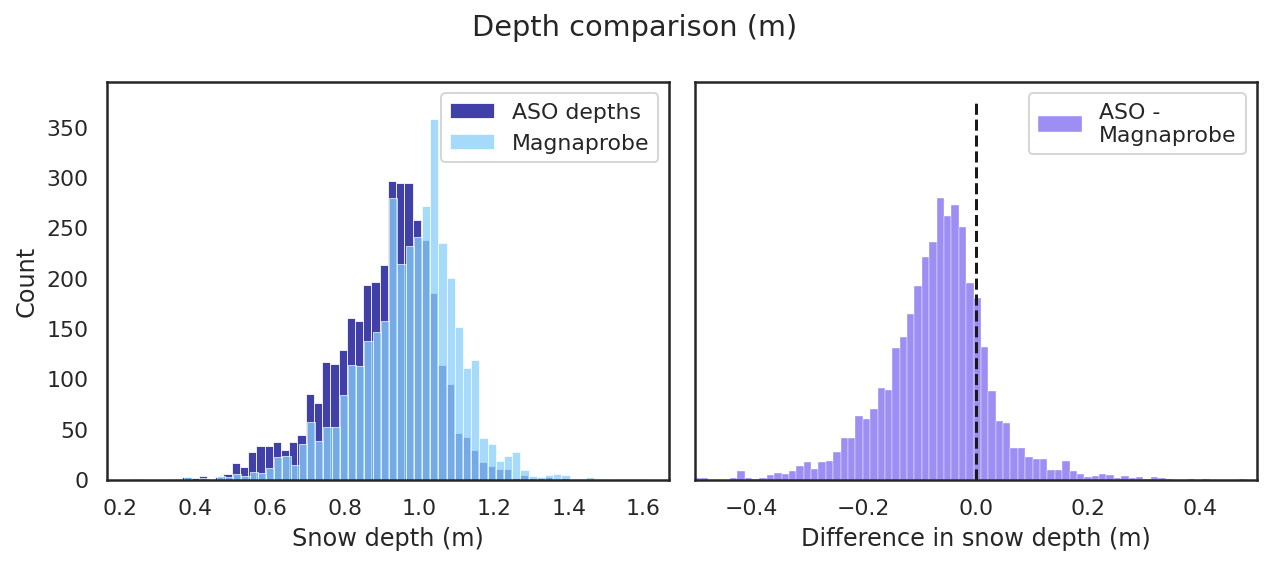

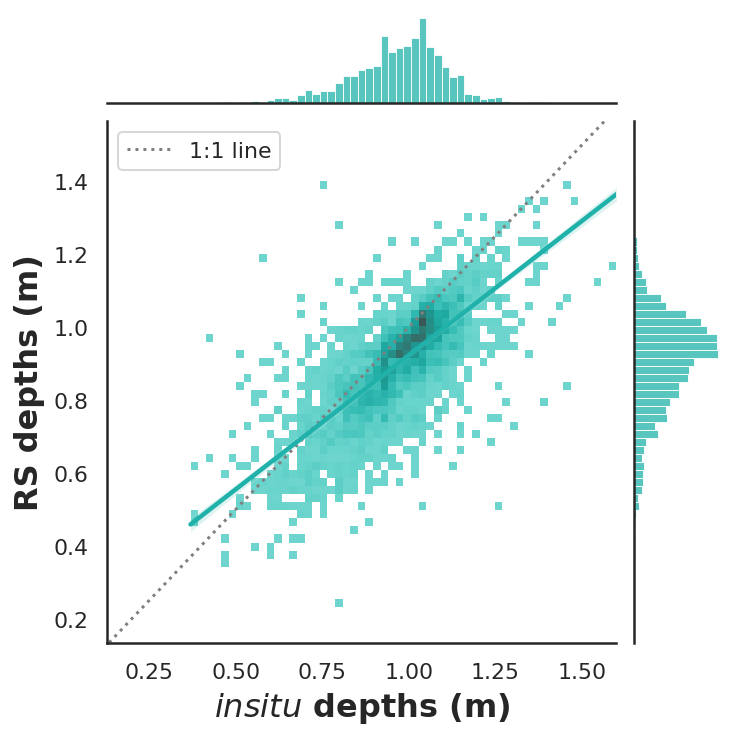

In [34]:
aso_sd_nonans, stripped_nonans, aso_sd_points, stripped = extract_nonan_gdfs(aso_sd_2020, df, out_fn=out_fn)
check_extracts(stripped_nonans, aso_sd_nonans)
compare_depths(aso_sd_nonans, stripped_nonans, histlabels=['ASO depths', f'{instrument.capitalize()}', f'ASO - \n{instrument.capitalize()}'],)

##### **Special** handling for GPR

In [33]:
run_it=True

pulse EKKO Pro multi-polarization 1 GHz GPR 

 2020-01-28 has 531650 entries


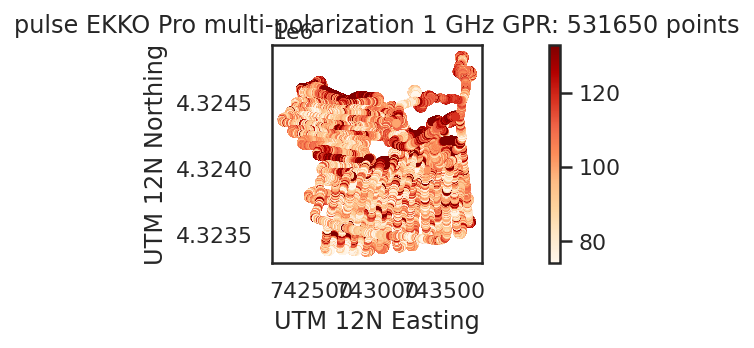

In [34]:
if run_it:
    timestamp='2020-01-28'
    instrument='pulse EKKO Pro multi-polarization 1 GHz GPR'

    df=grabngo(PointData, 'depth', instrument, timestamp, 
               session, engine, get_df=True)

    quickplot(df, figsize=(12, 2), cmap='OrRd', vmin=np.percentile(df.value, 5),
            vmax=np.percentile(df.value, 95))

    check_entrydates(df)

    # Burn to file
    if len(instrument.split(' '))>0:
        instrument='_'.join(instrument.split(' '))

    out_fn=f'{instrument}_depths_{timestamp}.tif'
    gdf=df

if not os.path.exists(out_fn):
    print(f'Writing to raster...')
    burn_baby_burn(template_fn, out_fn, gdf)

(21680,) (21680,)
0 0


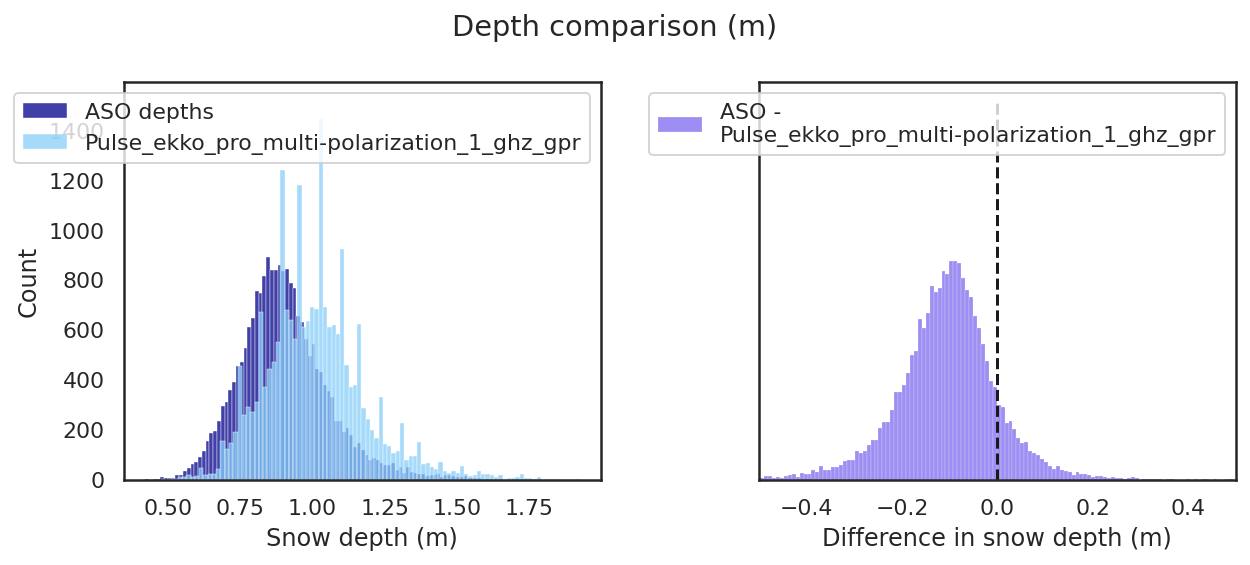

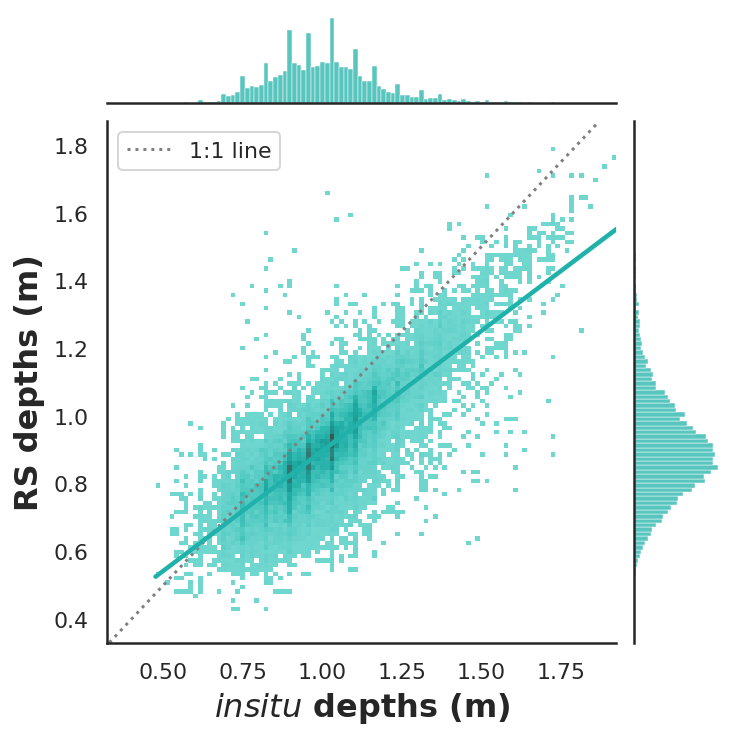

In [35]:
aso_sd_nonans, stripped_nonans, aso_sd_points, stripped = extract_nonan_gdfs(aso_sd_2020, df, out_fn=out_fn)
check_extracts(stripped_nonans, aso_sd_nonans)
compare_depths(aso_sd_nonans, stripped_nonans, histlabels=['ASO depths', f'{instrument.capitalize()}', f'ASO - \n{instrument.capitalize()}'],)

## 4. Re-load extracted rasters, clean and compare depths!

In [35]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return img[ymin:ymax+1, xmin:xmax+1]

def extract_nonan_gdfs(raster, gdf, out_fn, check_all=None, ndv=-9999):
    
    '''Extract raster values with specified geometries'''
    
    extract_gdf=raster.rio.clip(gdf.geometry)
    extract_gdf.values[extract_gdf.values==ndv]=np.nan
    
    df_fromdisk=load(out_fn, 'in situ measures (cm)', masked=False)
    ndv=df_fromdisk._FillValue
    
    # specify for bbox2 extent clipping
    df_fromdisk.values[df_fromdisk.values==ndv]=0
    
    stripped=bbox2(df_fromdisk)
    stripped.values[stripped.values==0]=np.nan
    
    # Remove the nans from the raster clips
    extract_gdf_nonans=extract_gdf.values[~np.isnan(extract_gdf.values)]
    gdf_nonans=stripped.values[~np.isnan(extract_gdf.values)]
    
    if check_all:
        print(extract_gdf.shape, gdf.shape, np.isnan(extract_gdf.values).sum(), np.isnan(gdf.values).sum())
    
    return extract_gdf_nonans, gdf_nonans, extract_gdf, stripped

def check_extracts(extract1, extract2):
    print(extract1.shape, extract2.shape)
    print(np.isnan(extract1).sum(), np.isnan(extract2).sum())

In [36]:
# fig, ax = plt.subplots(figsize=(12,6))

# aso_sd_2020.plot(cmap='Blues', vmin=0, vmax=1.5, ax=ax, 
#                  cbar_kwargs={'label': 'ASO Snow Depth $m$'}
#                 )

# magna_df.plot(ax=ax, color='k', marker='.');

#### Prepare gdfs for plotting comparisons

In [37]:
gdf_extracts = extract_nonan_gdfs(aso_sd_2020, magna_df, out_fn='magnaprobe_depths_2020-02-01.tif')

aso_sd_magna_nonans, stripped_magna_nonans, aso_sd_magnapoints, stripped_magna = gdf_extracts
del gdf_extracts

check_extracts(stripped_magna_nonans, aso_sd_magna_nonans)

(3696,) (3696,)
0 0


(4322970.0, 4322850.0)

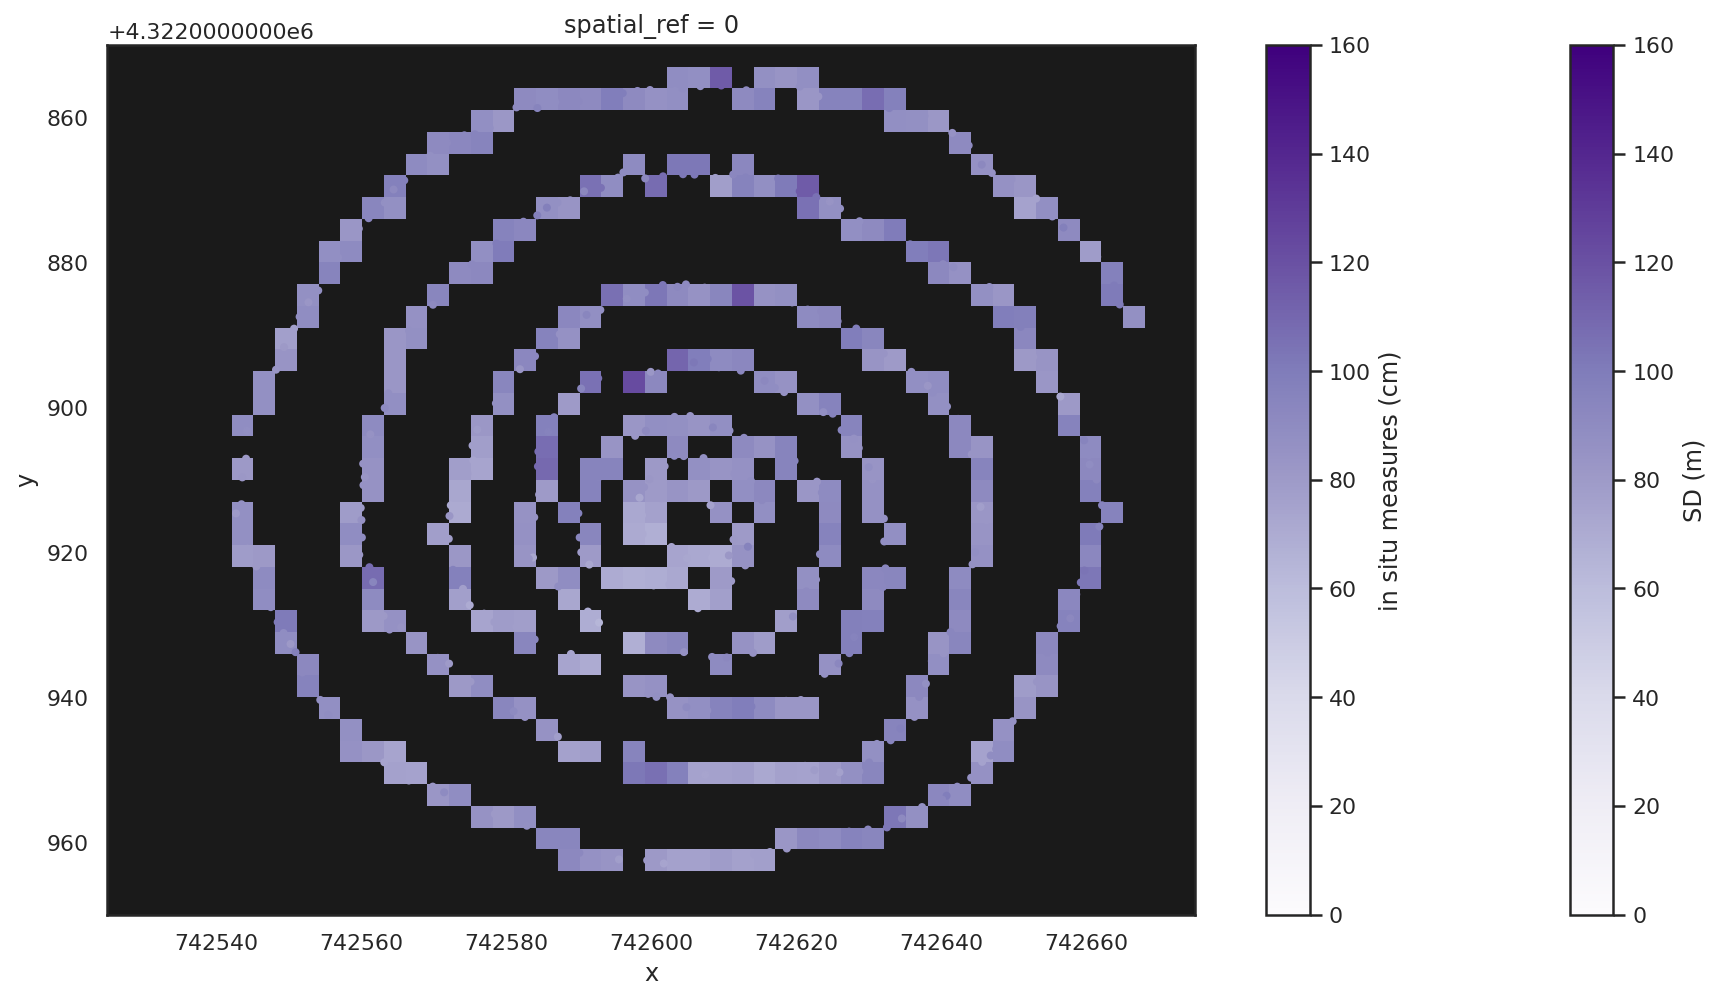

In [38]:
# Zoom zoom
# check to see that the values are actually making sense
vmin=0
vmax=160

fig, ax = plt.subplots(figsize=(16,8))
# raster sampled by geometry clipping 
(aso_sd_magnapoints*100).plot(ax=ax, 
                        cmap='Purples', vmin=vmin, vmax=vmax
                       )
# rasterized points read from disk
stripped_magna.plot(ax=ax, 
                    cmap='Purples', vmin=vmin, vmax=vmax
                   )
# from database
magna_df.plot(column='value', ax=ax, marker='.', cmap="Purples", vmin=vmin, vmax=vmax);
ax.set_facecolor('k')
ax.set_xlim(742525, 742675)
ax.set_ylim(4322970, 4322850)

### Looks pretty good

## plot histograms of aso snow depth, in situ snow depth, and difference between aso and in situ depth

In [39]:
def compare_depths(extract_gdf_nonans, insitu_gdf_nonans, adjust_meters=True,
                   style='white', figsize=(9, 4), sharey=True, 
                   histlabels=['ASO depths', 'Magnaprobe', 'ASO  - \nMagnaprobe'], 
                   histcolors=['darkblue', 'lightskyblue', 'mediumslateblue'],
                   xlabels=["Snow depth (m)", "Difference in snow depth (m)"],
                   title=f'Depth comparison (m)',
                   vlinecolor='k', vlinestyle="--",
                   xlims=[-0.5, 0.5],
                   jointcolor='lightseagreen', upper=None, lower=None, jointheight=5,
                   oneonestyle=':', oneonecolor='gray'
                  ):

    if adjust_meters:
        insitu_gdf_nonans=insitu_gdf_nonans/100
    plt.rcParams.update({'font.size': 12})
    sns.set_theme(style=style)

    fig, axa = plt.subplots(1, 2, figsize=figsize, sharey=sharey)
    ax=axa[0]
    sns.histplot(extract_gdf_nonans, 
                 label=histlabels[0], 
                 color=histcolors[0],
                 ax=ax
                )
    sns.histplot(insitu_gdf_nonans, 
                 label=histlabels[1], 
                 color=histcolors[1],
                 ax=ax
                )
    ax.set_xlabel(xlabels[0])
    ax.legend()

    ax=axa[1]
    sns.histplot(extract_gdf_nonans - insitu_gdf_nonans, 
                 label=histlabels[2], 
                 color=histcolors[2],
                 ax=ax
                )
    ax.vlines(0, 0, round(ax.get_ylim()[1], ndigits=4), color=vlinecolor, linestyle=vlinestyle)
    ax.set_xlim(xlims[0], xlims[1])
    ax.set_xlabel(xlabels[1])
    ax.legend()

    plt.suptitle(title)
    plt.tight_layout()

    x=extract_gdf_nonans
    y=insitu_gdf_nonans
    s=sns.jointplot(x=x, y=y, color=jointcolor,
                    kind="hist", height=jointheight,
                   )
    ax=s.ax_joint
    if not upper:
        upper=np.round(extract_gdf_nonans.max()*10+0.5, 0)/10
        lower=np.round(extract_gdf_nonans.min()*10-0.5, 0)/10
    ax.axline((lower,lower), (upper,upper), ls=oneonestyle, color=oneonecolor, label=f'1:1 line')
    q=sns.regplot(ax=ax, x=x, y=y, color=jointcolor, scatter=False)
    ax.legend()

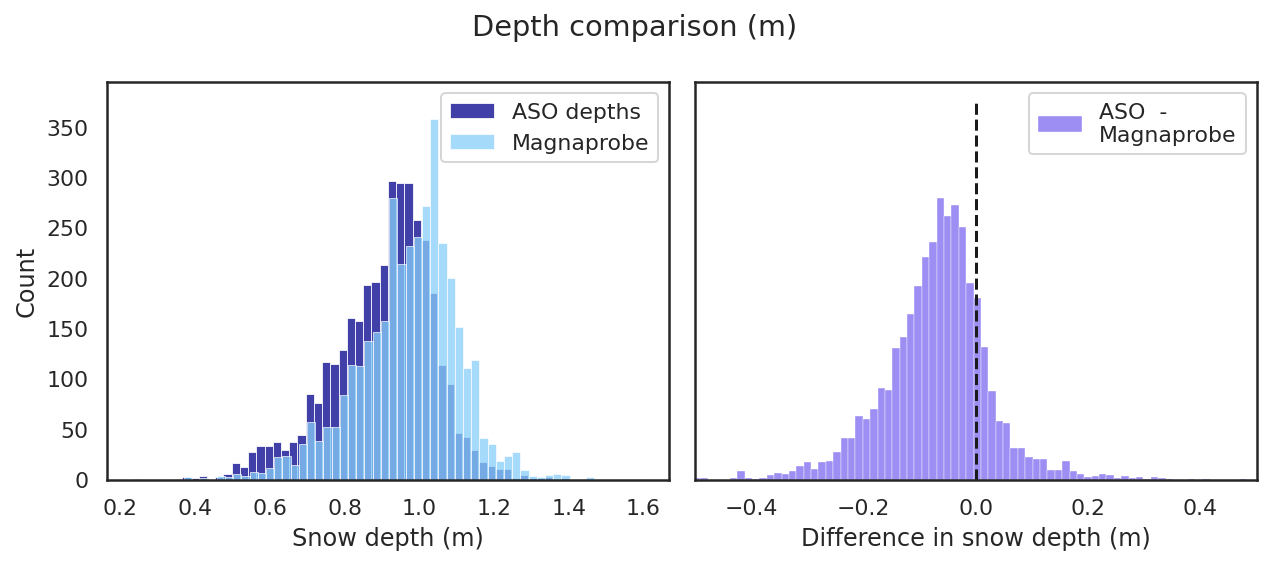

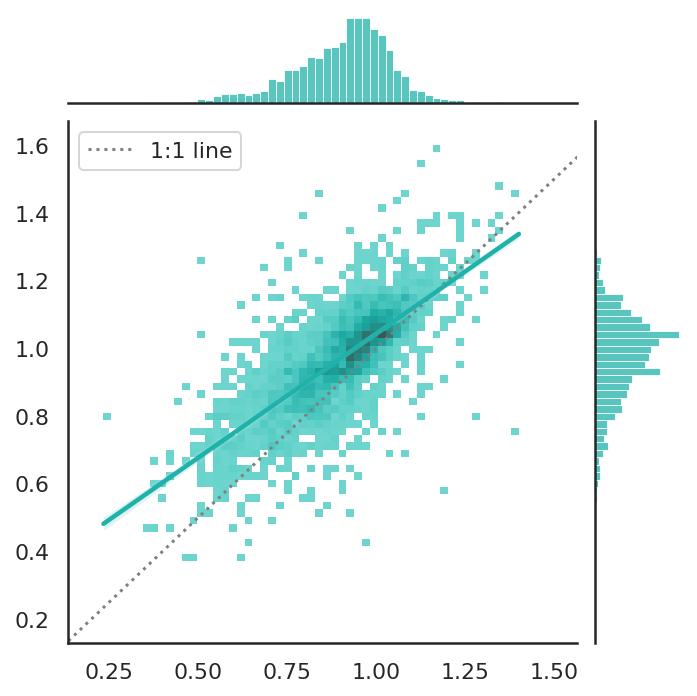

In [40]:
compare_depths(aso_sd_magna_nonans, stripped_magna_nonans)

## Take the depths and turn them into SWE

---
#### Check that the raster has the same values/distributions as the entries

In [41]:
gpr=load(fn_list("./", "*GPR*tif")[0], "gpr cm", masked=False)

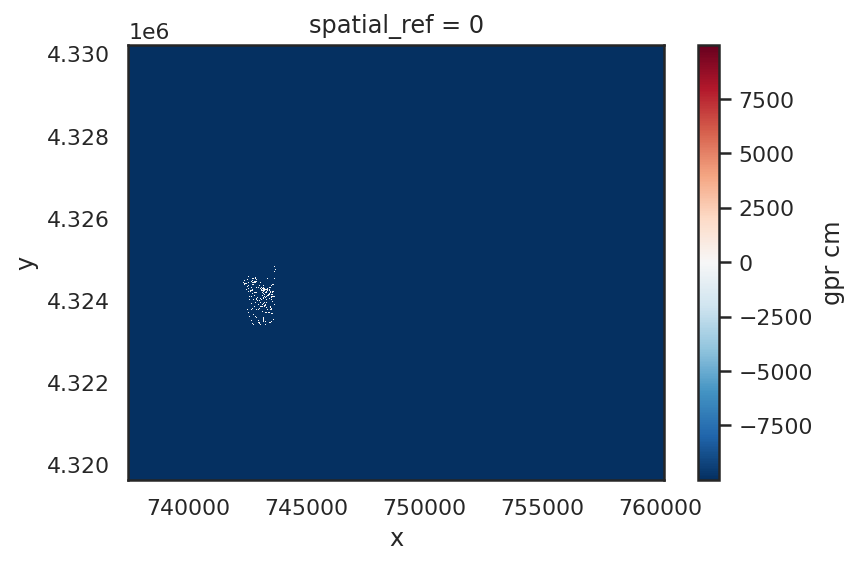

In [42]:
gpr.plot()

In [43]:
gpr.values[gpr.values==-9999]=0

In [44]:
gpr=bbox2(gpr)

In [45]:
gpr.values[gpr.values==0]=np.nan

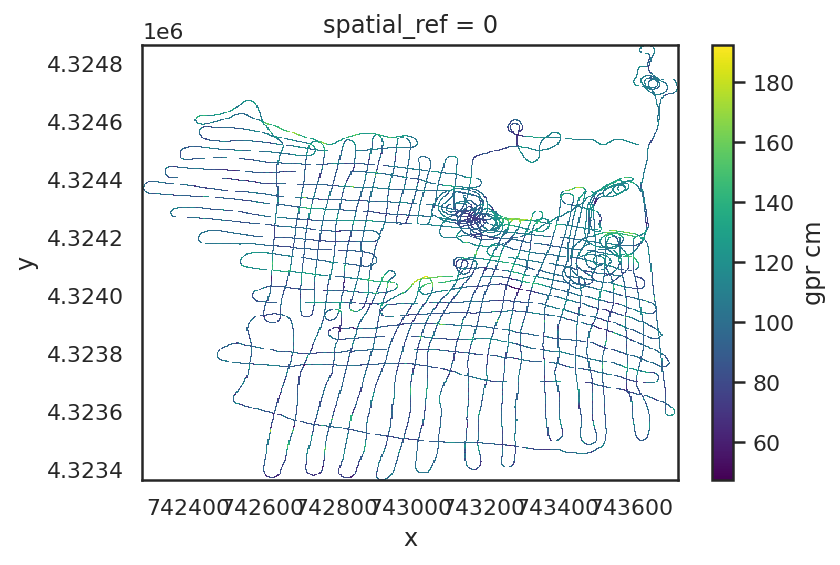

In [46]:
gpr.plot()

In [47]:
len(gpr.values[~np.isnan(gpr.values)])

21680

<AxesSubplot:ylabel='Count'>

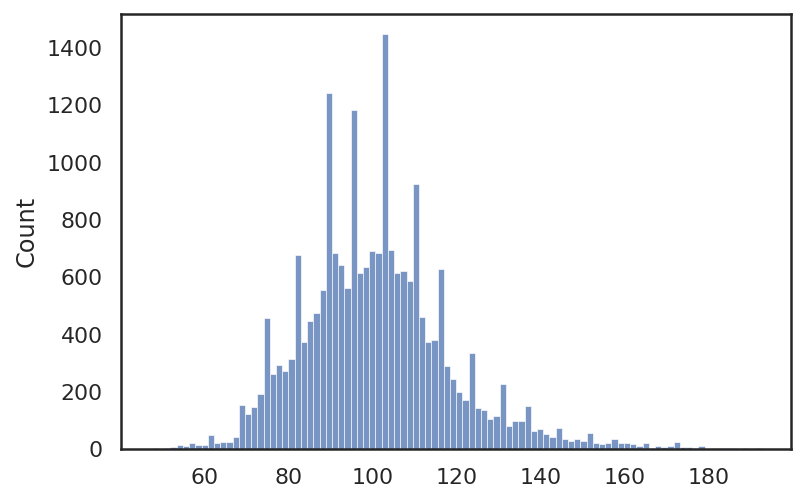

In [48]:
fig, ax = plt.subplots(1)
h=sns.histplot(np.ravel(gpr.values), ax=ax);
sns.histplot(ax=ax)

pulse EKKO Pro multi-polarization 1 GHz GPR 

 2020-01-28 has 531650 entries
CPU times: user 59.2 s, sys: 657 ms, total: 59.9 s
Wall time: 1min


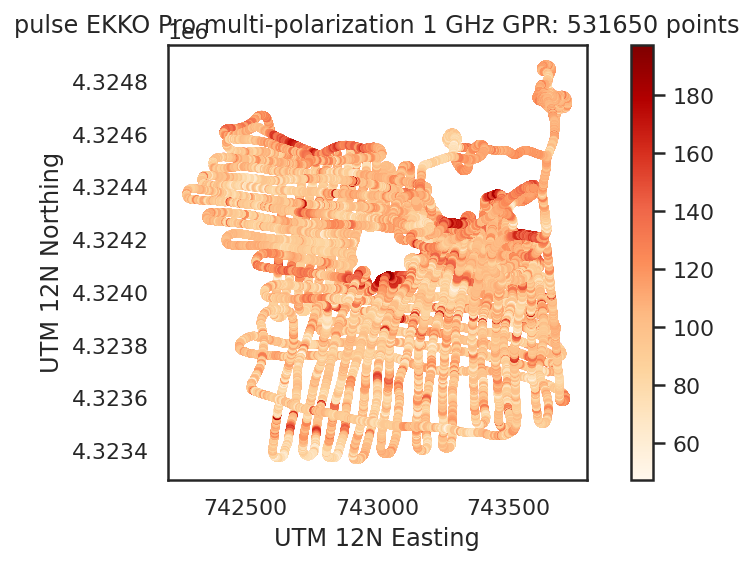

In [49]:
%%time
timestamp='2020-01-28'
df=grabngo(PointData, 'depth', 'pulse EKKO Pro multi-polarization 1 GHz GPR', timestamp, 
           session, engine, get_df=True)
quickplot(df, 
#           figsize=(12, 2), 
          cmap='OrRd')
check_entrydates(df)

In [50]:
df.describe()

id       latitude      longitude      northing  \
count  5.316500e+05  531650.000000  531650.000000  5.316500e+05   
mean   1.881830e+06      39.032062    -108.191283  4.324089e+06   
std    1.534743e+05       0.002798       0.004001  3.100511e+02   
min    1.616005e+06      39.025589    -108.200928  4.323364e+06   
25%    1.748917e+06      39.030025    -108.194556  4.323864e+06   
50%    1.881830e+06      39.032348    -108.190931  4.324124e+06   
75%    2.014742e+06      39.034082    -108.187693  4.324311e+06   
max    2.147654e+06      39.038896    -108.184109  4.324864e+06   

             easting          value  
count  531650.000000  531650.000000  
mean   743122.245703     100.646355  
std       347.169187      17.613576  
min    742277.801000      47.503285  
25%    742840.111250      88.916406  
50%    743154.164000      99.878703  
75%    743433.017250     109.622966  
max    743724.506000     197.321339

In [51]:
gpr_df_fromdisk=gpr.to_dataframe()

In [52]:
gpr_df_fromdisk.describe()

spatial_ref        gpr cm
count     242484.0  21680.000000
mean           0.0    100.936554
std            0.0     17.565155
min            0.0     47.503284
25%            0.0     88.916405
50%            0.0     99.878700
75%            0.0    109.622963
max            0.0    192.449203

In [53]:
df.value.describe() - gpr_df_fromdisk['gpr cm'].describe()

count    5.099700e+05
mean    -2.901985e-01
std      4.842085e-02
min      9.114566e-07
25%      1.216996e-06
50%      2.307647e-06
75%      3.277115e-06
max      4.872136e+00
dtype: float64

Differences in the mean are on the order of 0.3 cm and all other statistics are on the order of 1E-5 except for counts. Due to burning into a raster template that is ~3m resolution, we reduce the sample number. Values were aggregated according to https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster. 

CPU times: user 9min 24s, sys: 217 ms, total: 9min 24s
Wall time: 9min 22s


<AxesSubplot:xlabel='easting', ylabel='northing'>

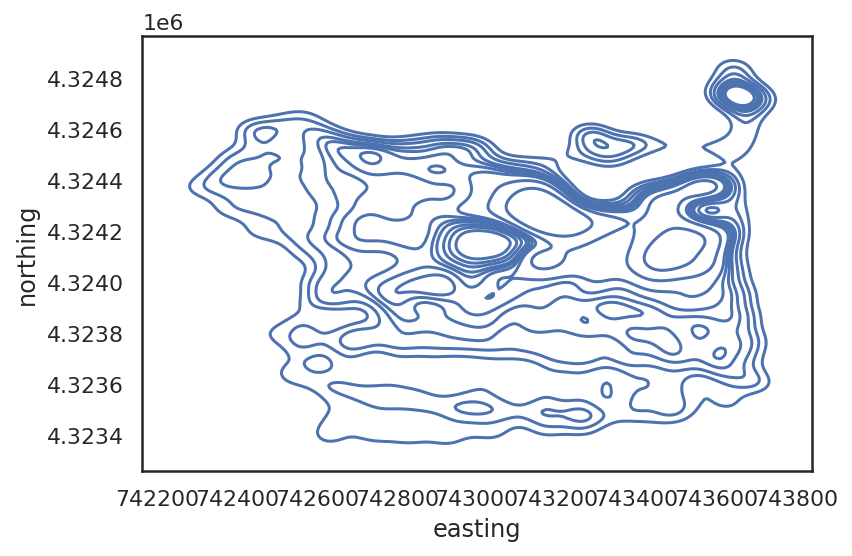

In [53]:
%%time
sns.kdeplot(data=df.value, x=df.easting, y=df.northing)

In [54]:
del df, gpr, gpr_df_fromdisk, aso_sd_magna_nonans, stripped_magna_nonans, aso_sd_magnapoints, stripped_magna, aso_sd_nonans, stripped_nonans, aso_sd_points, stripped

In [55]:
# Close the session to avoid hanging transactions
session.close()

Exception during reset or similar
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/sqlalchemy/engine/base.py", line 749, in _rollback_impl
    self.engine.dialect.do_rollback(self.connection)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.


The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 891, in _reset
    self._reset_agent.rollback()
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/s

---

## Grab all ASO DEMs and check them out

#### Grab zipfiles

In [56]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0201/ASO_GrandMesa_dems_2020Feb1-2.zip

In [57]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb13.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0213/ASO_GrandMesa_dems_2020Feb13.zip

### Extract

In [58]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2/"):
    !for f in ASO*zip ; do unzip ${f} ; done

### Prep the dems

In [59]:
aso_fns=fn_list("./", "ASO*/*d?m*m.tif")
aso_dems=[load(fn, name="ASO Elevation (m)") for fn in aso_fns]
for dem in aso_dems:
    dem.values[dem.values==-9999]=np.nan
    dem.attrs['long_name']='Elevation (m)'

In [60]:
# Specify cmap
cmap='magma'

# # Get bounds for same range plotting
# vmin=np.nanmin(aso_dems)
# vmax=np.nanmax(aso_dems)
# vmin, vmax

# Restrict to just on-mesa happenings
vmin=3000
vmax=3300
vmin, vmax

(3000, 3300)

Plot dems

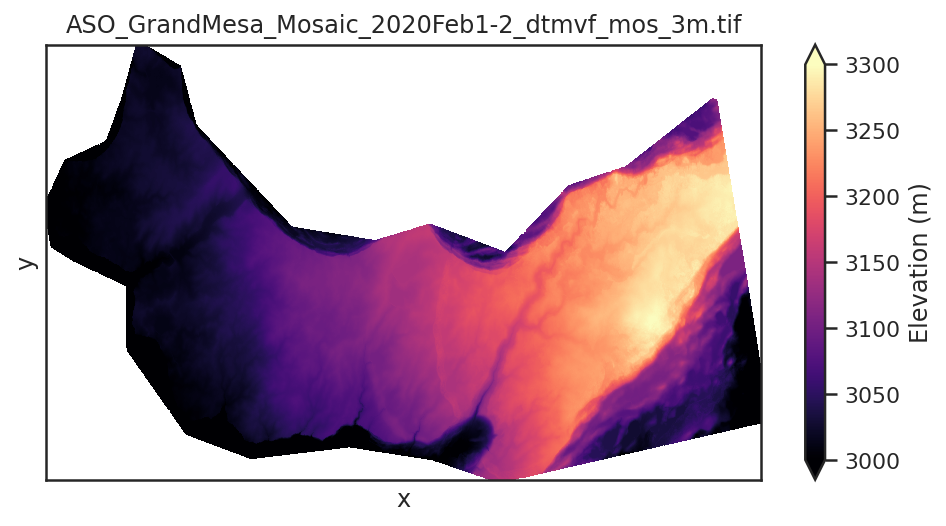

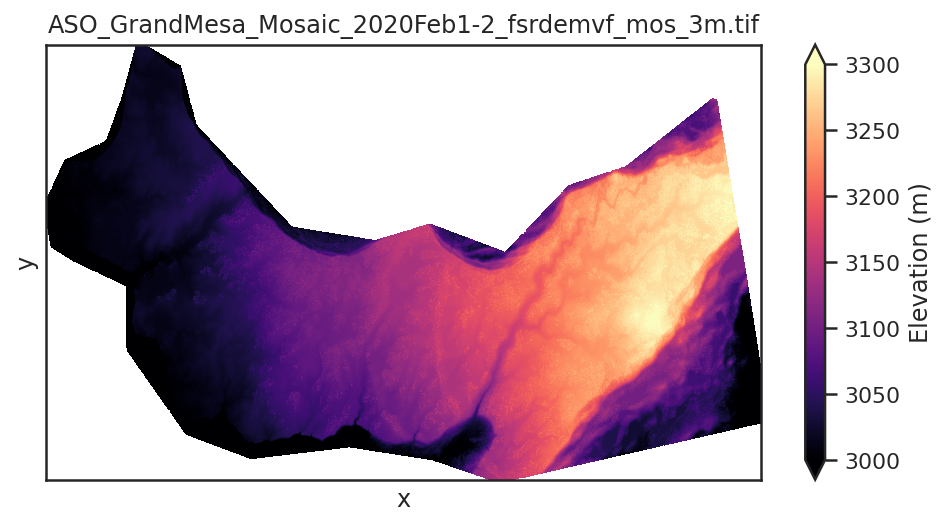

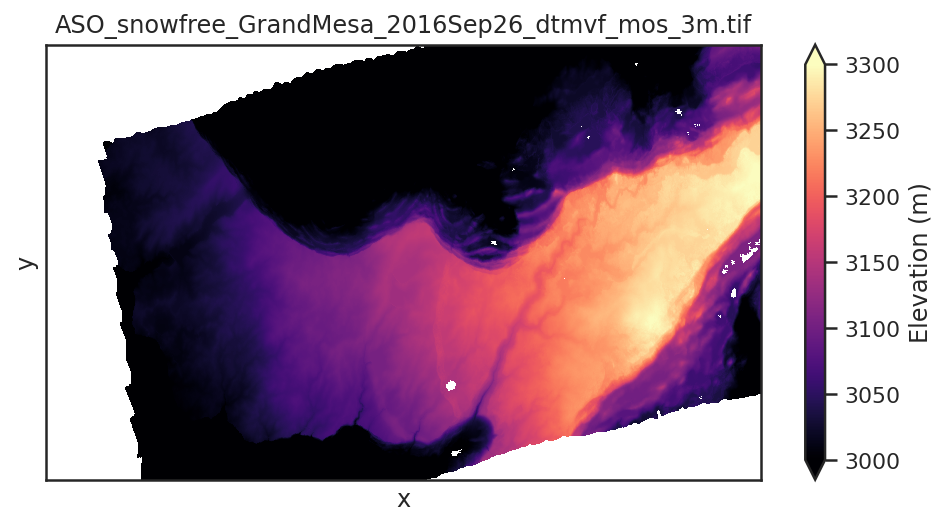

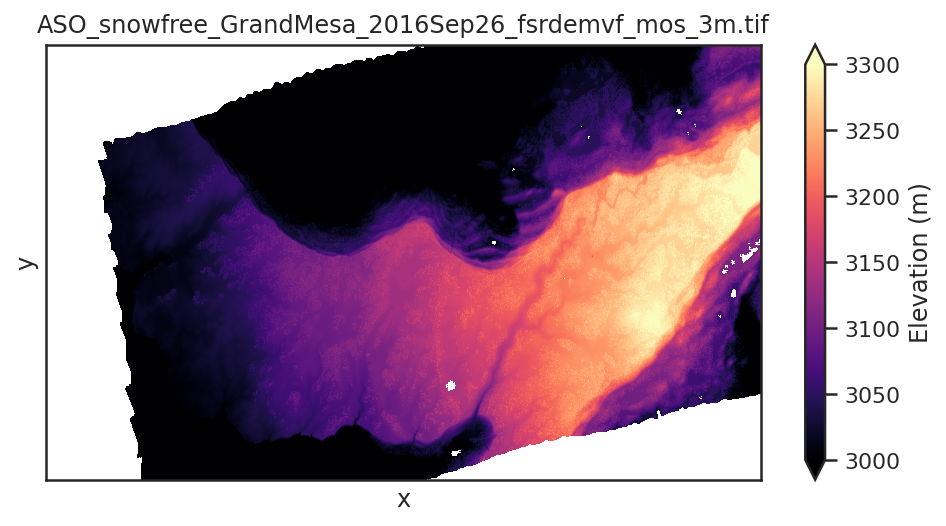

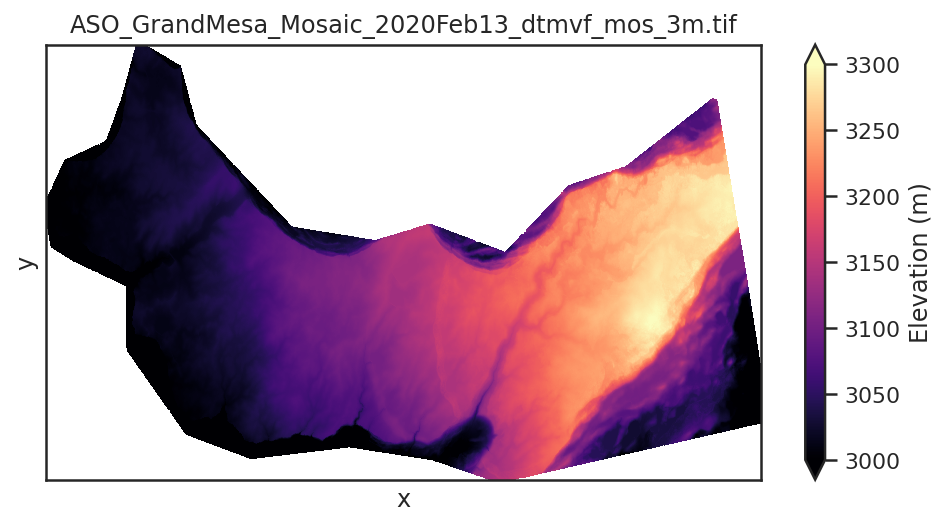

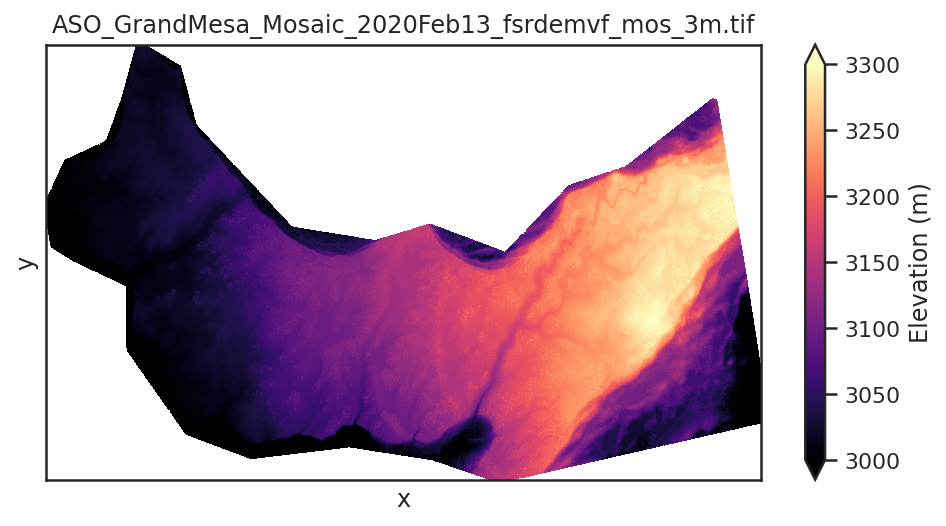

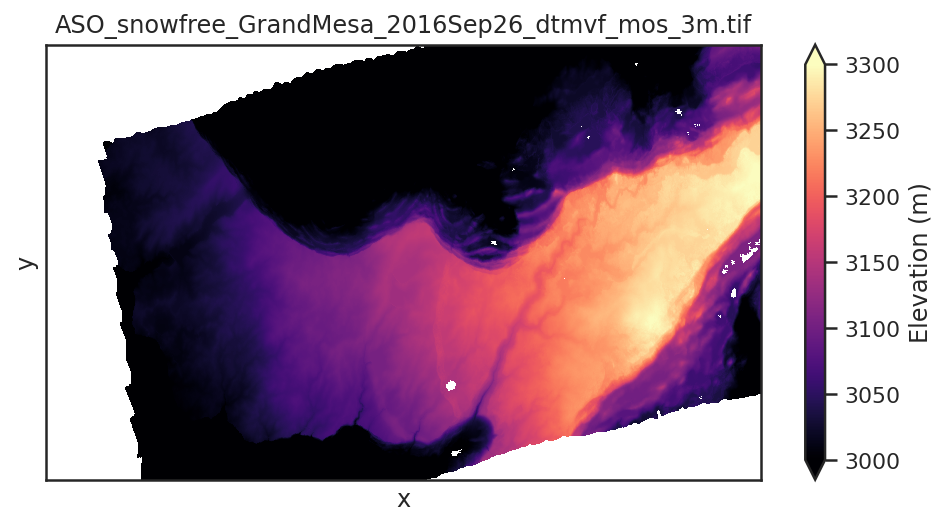

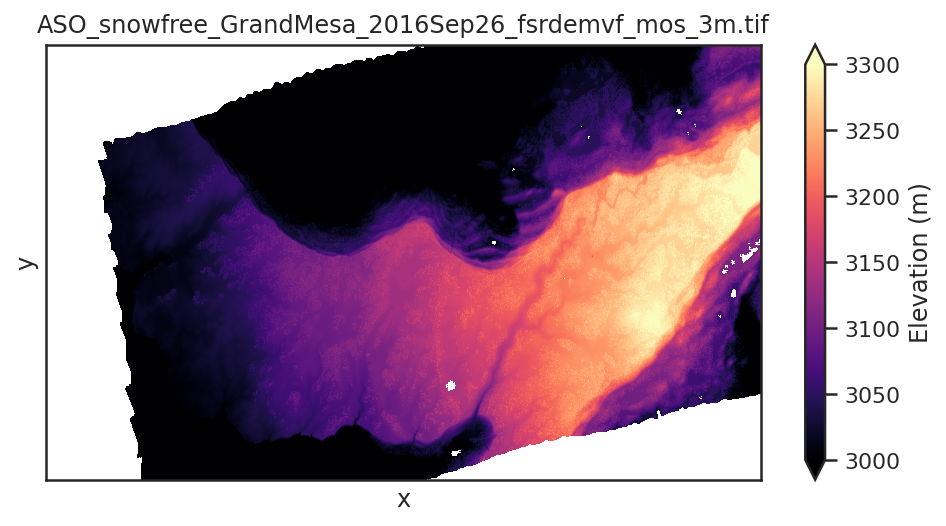

In [61]:
for dem, fn in zip(aso_dems, aso_fns):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.set_aspect('equal')
    dem.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap)
    
    ax.set_title(f'{os.path.basename(fn)}')
    ax.set_xticks(())
    ax.set_yticks(())

In [62]:
for fn in aso_fns:
    out_fn=os.path.splitext(fn)[0]+"_hs.tif"
    if not os.path.exists(out_fn):
        !gdaldem hillshade $fn $out_fn

In [63]:
hs_fns=fn_list("./", "ASO*/*hs.tif")
hs_fns

['./ASO_GrandMesa_dems_2020Feb1-2/ASO_GrandMesa_Mosaic_2020Feb1-2_dtmvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb1-2/ASO_GrandMesa_Mosaic_2020Feb1-2_fsrdemvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb1-2/ASO_snowfree_GrandMesa_2016Sep26_dtmvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb1-2/ASO_snowfree_GrandMesa_2016Sep26_fsrdemvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb13/ASO_GrandMesa_Mosaic_2020Feb13_dtmvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb13/ASO_GrandMesa_Mosaic_2020Feb13_fsrdemvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb13/ASO_snowfree_GrandMesa_2016Sep26_dtmvf_mos_3m_hs.tif',
 './ASO_GrandMesa_dems_2020Feb13/ASO_snowfree_GrandMesa_2016Sep26_fsrdemvf_mos_3m_hs.tif',
 './ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports/ASO_GrandMesa_2020Feb1-2_broadband_albedo_50m_hs.tif',
 './ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports/ASO_GrandMesa_2020Feb1-2_snowdepth_3m_hs.tif',
 './ASO_GrandMesa_mosaic_2020Feb1-2_AllData_and_Reports/ASO_GrandMesa_Mo

In [64]:
aso_hs=[load(fn, name="Hillshade") for fn in hs_fns]

In [ ]:
for hs, fn in zip(aso_hs, hs_fns):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.set_aspect('equal')
    hs.plot.imshow(cmap='Greys', 
#                    vmin=vmin, vmax=vmax, 
                  )
    
    ax.set_title(f'{os.path.basename(fn)}')
    ax.set_xticks(())
    ax.set_yticks(())

### Re-create ASO snow depths

use rioxarray  
snow depth 2020 = aso snow on 2020 - aso snow off 2016 (or 3DEP snow off)

In [ ]:
# # aso dem 20 - aso dtm 20 = chm for fun
# diff=aso_dem20-aso_dtm20

# # use big chm values to mask open vs. covered
# thresh=1
# covered=diff[diff>thresh]
# gap_open=diff[diff<=thresh]


In [ ]:
# aso_sd_fn #processed product
# snowoff_aso_16 # 3dep raster (in db)
# snowoff_3dep # 3dep raster (in db)
# manual_sd #computed product